/tmp/ipykernel_19975/72282936.py:128: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")


Train/Val/Test seq lens: 11526/2451/2452
Test set starts at: 2013-08-14 17:00:00

== Model 1/3 (seed=42) ==
Epoch 001 | Val SmoothL1: 0.175448
Epoch 002 | Val SmoothL1: 0.172974
Epoch 003 | Val SmoothL1: 0.176368
Epoch 004 | Val SmoothL1: 0.169632
Epoch 005 | Val SmoothL1: 0.166902
Epoch 006 | Val SmoothL1: 0.170116
Epoch 007 | Val SmoothL1: 0.202895
Epoch 008 | Val SmoothL1: 0.177028
Epoch 009 | Val SmoothL1: 0.182951
Epoch 010 | Val SmoothL1: 0.173672
Epoch 011 | Val SmoothL1: 0.172439
Epoch 012 | Val SmoothL1: 0.175519
Epoch 013 | Val SmoothL1: 0.183510
Epoch 014 | Val SmoothL1: 0.187306
Epoch 015 | Val SmoothL1: 0.191093
Epoch 016 | Val SmoothL1: 0.200609
Epoch 017 | Val SmoothL1: 0.208185
Epoch 018 | Val SmoothL1: 0.214907
Epoch 019 | Val SmoothL1: 0.208524
Epoch 020 | Val SmoothL1: 0.224296
Epoch 021 | Val SmoothL1: 0.231289
Epoch 022 | Val SmoothL1: 0.233493
Epoch 023 | Val SmoothL1: 0.233832
Early stopping at 23, best val 0.166902
[seed 42] RMSE=0.181546  MAE=0.126178  R²=0.666

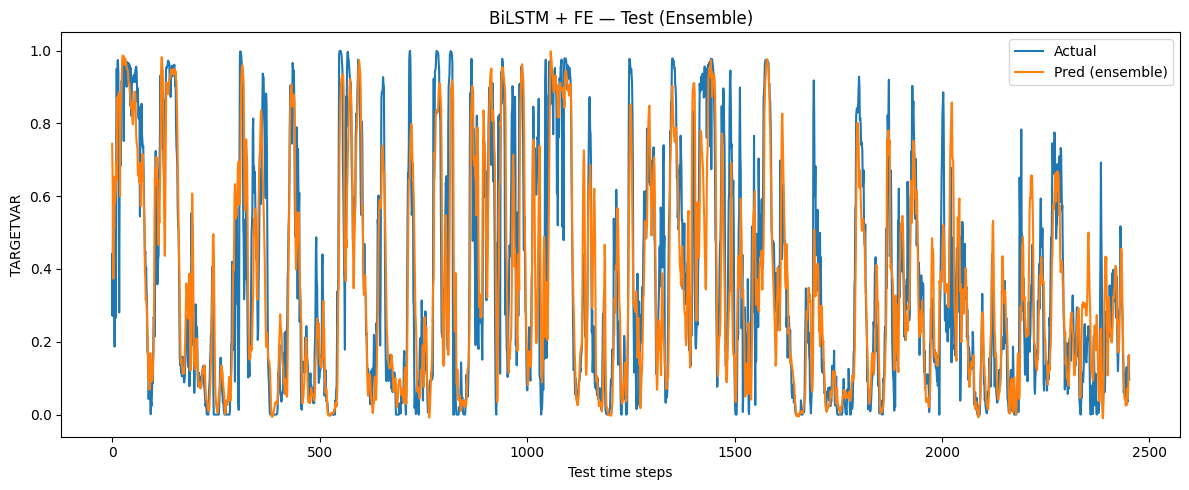

In [4]:
# improve_rmse_lstm_wind.py
import argparse, math, random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# ===================== CONFIG =====================
TIME_COL     = "TIMESTAMP"
TARGET_COL   = "TARGETVAR"
BASE_FEATS   = ["U10", "V10", "U100", "V100"]

# engineered & lag features
LAGS_Y       = [1, 3, 6, 12, 24]
LAGS_SPEED   = [1, 3, 6]          # for speed10/speed100
ROLLS_Y      = [6, 12, 24]        # rolling means of y, shifted

LOOKBACK     = 24
TRAIN_RATIO  = 0.70
VAL_RATIO    = 0.15               # TEST = rest

BATCH_SIZE   = 128
HIDDEN_SIZE  = 128
NUM_LAYERS   = 2
DROPOUT      = 0.2
LR           = 1e-3
MAX_EPOCHS   = 120
ES_PATIENCE  = 18
LR_PATIENCE  = 4
CLIP_NORM    = 1.0
ENSEMBLE_SEEDS = [42, 123, 2024]  # try 5+ for a tiny extra boost

BIDIRECTIONAL = True
LOG_TARGET     = False  # set True if target is skewed/heavy-tailed

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== UTILS =====================
def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # wind speed & direction (radians)
    out["speed10"]  = np.sqrt(out["U10"]**2  + out["V10"]**2)
    out["speed100"] = np.sqrt(out["U100"]**2 + out["V100"]**2)
    dir10  = np.arctan2(out["V10"],  out["U10"])
    dir100 = np.arctan2(out["V100"], out["U100"])
    out["dir10_sin"], out["dir10_cos"]   = np.sin(dir10),  np.cos(dir10)
    out["dir100_sin"], out["dir100_cos"] = np.sin(dir100), np.cos(dir100)
    # shear & veer
    out["shear_speed"] = out["speed100"] - out["speed10"]
    veer = dir100 - dir10
    out["veer_sin"], out["veer_cos"] = np.sin(veer), np.cos(veer)
    # time features (cyclic)
    out["hour"] = out[TIME_COL].dt.hour
    out["doy"]  = out[TIME_COL].dt.dayofyear
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24.0)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24.0)
    out["doy_sin"]  = np.sin(2*np.pi*out["doy"]/366.0)
    out["doy_cos"]  = np.cos(2*np.pi*out["doy"]/366.0)
    # target lags (shifted to avoid leakage)
    for L in LAGS_Y:
        out[f"y_lag{L}"] = out[TARGET_COL].shift(L)
    # rolling means of y (shift before rolling to avoid using current value)
    for W in ROLLS_Y:
        out[f"y_roll{W}"] = out[TARGET_COL].shift(1).rolling(window=W, min_periods=W).mean()
    # speed lags
    for L in LAGS_SPEED:
        out[f"speed10_lag{L}"]  = out["speed10"].shift(L)
        out[f"speed100_lag{L}"] = out["speed100"].shift(L)
    return out

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i, :])
        ys.append(y[i, 0])
    return np.array(Xs, np.float32), np.array(ys, np.float32).reshape(-1,1)

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class BiLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
            bidirectional=bidirectional
        )
        out_size = hidden_size * (2 if bidirectional else 1)
        self.norm = nn.LayerNorm(out_size)
        self.head = nn.Sequential(
            nn.Linear(out_size, out_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(out_size, 1),
        )
    def forward(self, x):
        o, _ = self.lstm(x)          # (B,T,H*dir)
        last = o[:, -1, :]
        last = self.norm(last)
        return self.head(last)

# ===================== DATA LOAD =====================
def load_data(file_path: str, sheet: str):
    df = pd.read_excel(file_path)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

def prepare_splits(df: pd.DataFrame):
    df = add_engineered_features(df)
    # target transform (optional)
    if LOG_TARGET:
        df["_y"] = np.log1p(df[TARGET_COL].clip(min=0))
    else:
        df["_y"] = df[TARGET_COL].astype(float)

    # drop rows made NaN by lags/rolls
    df = df.dropna().reset_index(drop=True)

    # Build full feature list
    feat_cols = (
        BASE_FEATS +
        ["speed10","speed100","dir10_sin","dir10_cos","dir100_sin","dir100_cos",
         "shear_speed","veer_sin","veer_cos","hour_sin","hour_cos","doy_sin","doy_cos"] +
        [f"y_lag{L}" for L in LAGS_Y] +
        [f"y_roll{W}" for W in ROLLS_Y] +
        [f"speed10_lag{L}" for L in LAGS_SPEED] +
        [f"speed100_lag{L}" for L in LAGS_SPEED]
    )

    # chronological split
    n = len(df)
    n_train = int(n * TRAIN_RATIO)
    n_val   = int(n * (TRAIN_RATIO + VAL_RATIO))
    tr = df.iloc[:n_train].reset_index(drop=True)
    va = df.iloc[n_train:n_val].reset_index(drop=True)
    te = df.iloc[n_val:].reset_index(drop=True)

    X_tr, y_tr = tr[feat_cols].to_numpy(np.float32), tr[["_y"]].to_numpy(np.float32)
    X_va, y_va = va[feat_cols].to_numpy(np.float32), va[["_y"]].to_numpy(np.float32)
    X_te, y_te = te[feat_cols].to_numpy(np.float32), te[["_y"]].to_numpy(np.float32)

    # scale (fit on train only)
    xsc = StandardScaler().fit(X_tr)
    ysc = StandardScaler().fit(y_tr)
    X_trs, y_trs = xsc.transform(X_tr), ysc.transform(y_tr)
    X_vas, y_vas = xsc.transform(X_va), ysc.transform(y_va)
    X_tes, y_tes = xsc.transform(X_te), ysc.transform(y_te)

    # sequences
    Xtr_seq, ytr_seq = make_sequences(X_trs, y_trs, LOOKBACK)
    Xva_seq, yva_seq = make_sequences(X_vas, y_vas, LOOKBACK)
    Xte_seq, yte_seq = make_sequences(X_tes, y_tes, LOOKBACK)

    meta = {
        "feat_cols": feat_cols,
        "y_scaler": ysc,
        "x_scaler": xsc,
        "val_start_ts": va[TIME_COL].iloc[0],
        "test_start_ts": te[TIME_COL].iloc[0],
    }
    return (Xtr_seq, ytr_seq, Xva_seq, yva_seq, Xte_seq, yte_seq, meta)

# ===================== TRAIN / EVAL =====================
def train_one(Xtr, ytr, Xva, yva, input_size, seed=42, save_path=None):
    set_seed(seed)
    model = BiLSTMRegressor(input_size, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, BIDIRECTIONAL).to(DEVICE)
    loss_fn = nn.SmoothL1Loss(beta=0.5)  # Huber-like
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                                       patience=LR_PATIENCE)

    train_loader = DataLoader(SeqDS(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(SeqDS(Xva, yva), batch_size=BATCH_SIZE, shuffle=False)

    best_val = float("inf"); no_improve = 0; best_state = None

    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()

        # validate
        model.eval()
        vlosses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                vlosses.append(loss_fn(model(xb), yb).item())
        vmean = float(np.mean(vlosses))
        sched.step(vmean)
        print(f"Epoch {epoch:03d} | Val SmoothL1: {vmean:.6f}")

        if vmean < best_val - 1e-6:
            best_val = vmean; no_improve = 0
            best_state = model.state_dict()
            if save_path:
                torch.save(best_state, save_path)
        else:
            no_improve += 1
            if no_improve >= ES_PATIENCE:
                print(f"Early stopping at {epoch}, best val {best_val:.6f}")
                break

    if best_state is None:
        best_state = model.state_dict()
    model.load_state_dict(best_state)
    return model

def inverse_target(y_scaled, y_scaler):
    y = y_scaler.inverse_transform(y_scaled).ravel()
    if LOG_TARGET:
        y = np.expm1(y)
    return y

def evaluate(model, Xte, yte, y_scaler):
    loader = DataLoader(SeqDS(Xte, yte), batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    preds_s, trues_s = [], []
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb.to(DEVICE)).cpu().numpy()
            preds_s.append(pred); trues_s.append(yb.numpy())
    preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
    y_pred = inverse_target(preds_s, y_scaler)
    y_true = inverse_target(trues_s, y_scaler)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    smp  = smape(y_true, y_pred)
    return y_true, y_pred, {"RMSE": rmse, "MAE": mae, "R2": r2, "sMAPE": smp}

# ===================== MAIN =====================
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--file",  type=str, required=True)
    ap.add_argument("--sheet", type=str, default="WindPowerForecastingData")
    ap.add_argument("--outdir", type=str, default=".")
    args = ap.parse_args()

    outdir = Path(args.outdir); outdir.mkdir(parents=True, exist_ok=True)

    df = load_data("WindPowerForecastingData.xlsx", "aa")
    Xtr, ytr, Xva, yva, Xte, yte, meta = prepare_splits(df)
    print(f"Train/Val/Test seq lens: {len(Xtr)}/{len(Xva)}/{len(Xte)}")
    print(f"Test set starts at: {meta['test_start_ts']}")

    # Save scalers for later inference
    joblib.dump(meta["x_scaler"], outdir / "x_scaler_rmse.pkl")
    joblib.dump(meta["y_scaler"], outdir / "y_scaler_rmse.pkl")
    with open(outdir / "features.txt", "w") as f:
        f.write("\n".join(meta["feat_cols"]))

    input_size = Xtr.shape[-1]

    # ==== Ensemble training ====
    test_preds_list = []
    for i, sd in enumerate(ENSEMBLE_SEEDS, 1):
        print(f"\n== Model {i}/{len(ENSEMBLE_SEEDS)} (seed={sd}) ==")
        save_path = outdir / f"bilstm_seed{sd}.pt"
        model = train_one(Xtr, ytr, Xva, yva, input_size, seed=sd, save_path=save_path)
        y_true, y_pred, m = evaluate(model, Xte, yte, meta["y_scaler"])
        print(f"[seed {sd}] RMSE={m['RMSE']:.6f}  MAE={m['MAE']:.6f}  R²={m['R2']:.6f}  sMAPE={m['sMAPE']:.2f}%")
        test_preds_list.append(y_pred)

    # ==== Ensemble average ====
    y_pred_ens = np.mean(np.vstack(test_preds_list), axis=0)
    y_true = inverse_target(yte, meta["y_scaler"])
    rmse = math.sqrt(mean_squared_error(y_true, y_pred_ens))
    mae  = mean_absolute_error(y_true, y_pred_ens)
    r2   = r2_score(y_true, y_pred_ens)
    smp  = smape(y_true, y_pred_ens)
    print("\n==== ENSEMBLE (avg of seeds) ====")
    print(f"RMSE : {rmse:.6f}\nMAE  : {mae:.6f}\nR^2  : {r2:.6f}\nsMAPE: {smp:.2f}%")

    # plot
    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred_ens, label="Pred (ensemble)")
    plt.title("BiLSTM + FE — Test (Ensemble)")
    plt.xlabel("Test time steps"); plt.ylabel(TARGET_COL)
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "test_plot_bilstm_ensemble.png", dpi=150)

if __name__ == "__main__":
    main()
